In [6]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [22]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672550900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [9]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [10]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 13:44:59  1194.19  1194.10  1194.26  1193.52   541.5214
1     2023-01-01 13:59:59  1194.09  1194.54  1194.67  1194.09   520.3463
2     2023-01-01 14:14:59  1194.55  1194.09  1195.23  1193.97  1376.0106
3     2023-01-01 14:29:59  1194.09  1194.60  1194.92  1194.09  1068.8736
4     2023-01-01 14:44:59  1194.59  1194.37  1194.60  1193.81   642.7820
...                   ...      ...      ...      ...      ...        ...
8166  2023-03-27 16:29:59  1751.73  1752.44  1753.24  1749.77  2312.4005
8167  2023-03-27 16:44:59  1752.43  1754.11  1754.56  1751.49  2487.9269
8168  2023-03-27 16:59:59  1754.11  1756.20  1759.10  1754.02  2529.5700
8169  2023-03-27 17:14:59  1756.20  1754.69  1756.96  1754.68  1956.2810
8170  2023-03-27 17:29:59  1754.69  1754.53  1755.04  1754.49   143.5981

[8171 rows x 6 columns]


In [11]:
df = raw_df.copy()

In [12]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff()

In [13]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low     Volume  \
0     2023-01-01 13:44:59  1194.19  1194.10  1194.26  1193.52   541.5214   
1     2023-01-01 13:59:59  1194.09  1194.54  1194.67  1194.09   520.3463   
2     2023-01-01 14:14:59  1194.55  1194.09  1195.23  1193.97  1376.0106   
3     2023-01-01 14:29:59  1194.09  1194.60  1194.92  1194.09  1068.8736   
4     2023-01-01 14:44:59  1194.59  1194.37  1194.60  1193.81   642.7820   
...                   ...      ...      ...      ...      ...        ...   
8166  2023-03-27 16:29:59  1751.73  1752.44  1753.24  1749.77  2312.4005   
8167  2023-03-27 16:44:59  1752.43  1754.11  1754.56  1751.49  2487.9269   
8168  2023-03-27 16:59:59  1754.11  1756.20  1759.10  1754.02  2529.5700   
8169  2023-03-27 17:14:59  1756.20  1754.69  1756.96  1754.68  1956.2810   
8170  2023-03-27 17:29:59  1754.69  1754.53  1755.04  1754.49   143.5981   

            ema_8       ema_18       ema_38       atr        rsi     slow_k  \
0       

In [23]:
def pivot_id(df, l, n1, n2):
    if l - n1 < 0 or l + n2 >= len(df):
        return 0
    
    piv_id_low = 1
    piv_id_high = 1
    for i in range(l - n1, l + n2 + 1):
        if(df.Low[l] > df.Low[i]):
            piv_id_low = 0
        if(df.High[l] < df.High[i]):
            piv_id_high = 0
    if piv_id_low and piv_id_high:
        return 3
    elif piv_id_low:
        return 1
    elif piv_id_high:
        return 2
    else:
        return 0

def rsi_pivot_id(df, l, n1, n2):
    if l - n1 < 0 or l + n2 >= len(df):
        return 0
    
    piv_id_low = 1
    piv_id_high = 1
    for i in range(l - n1, l + n2 + 1):
        if(df.rsi[l] > df.rsi[i]):
            piv_id_low = 0
        if(df.rsi[l] < df.rsi[i]):
            piv_id_high = 0
    if piv_id_low and piv_id_high:
        return 3
    elif piv_id_low:
        return 1
    elif piv_id_high:
        return 2
    else:
        return 0

In [24]:
df['pivot'] = df.apply(lambda x: pivot_id(df, x.name, 5, 5), axis = 1)
df['rsi_pivot'] = df.apply(lambda x: rsi_pivot_id(df, x.name, 5, 5), axis = 1)

In [25]:
def point_pos(x):
    if x['pivot'] == 1:
        return x['Low'] - 1e-3
    elif x['pivot'] == 2:
        return x['High'] + 1e-3
    else:
        return np.nan
    
def rsi_point_pos(x):
    if x['rsi_pivot'] == 1:
        return x['rsi'] - 1
    elif x['rsi_pivot'] == 2:
        return x['rsi'] + 1
    else:
        return np.nan
    
df['point_pos'] = df.apply(lambda row: point_pos(row), axis = 1)
df['rsi_point_pos']= df.apply(lambda row: rsi_point_pos(row), axis = 1)

In [44]:
df_pl = df.copy()

fig = go.Figure(data = [go.Candlestick(x = df_pl.index,
                                       open = df_pl['Open'],
                                       high = df_pl['High'],
                                       low = df_pl['Low'],
                                       close = df_pl['Close'])])

fig = make_subplots(rows = 2, cols = 1)

fig.update_layout(width=960, height=800)

fig.append_trace(go.Candlestick(x = df_pl.index,
                               open = df_pl['Open'],
                               high = df_pl['High'],
                               low = df_pl['Low'],
                               close = df_pl['Close']), row = 1, col = 1)


fig.add_scatter(x = df_pl.index, y = df_pl['point_pos'], mode = 'markers',
               marker = dict(size = 3, color = 'MediumPurple'),
               name = 'pivot', row = 1, col = 1)

fig.append_trace(go.Scatter(x = df_pl.index, y = df_pl['rsi']), row = 2, col = 1)

fig.add_scatter(x = df_pl.index, y = df_pl['rsi_point_pos'], mode = 'markers',
               marker = dict(size = 4, color = 'MediumPurple'),
               name = 'pivot', row = 2, col = 1)

fig.update_layout(xaxis_rangeslider_visible = False)
fig.show()

In [52]:
back_candles = 60

candle_id = 290

maxim = np.array([])
minim = np.array([])
xxmin = np.array([])
xxmax = np.array([])

maxim_rsi = np.array([])
minim_rsi = np.array([])
xxmin_rsi = np.array([])
xxmax_rsi = np.array([])

for i in range(candle_id - back_candles, candle_id + 1):
    if df.iloc[i].pivot == 1:
        minim = np.append(minim, df.iloc[i].Low)
        xxmin = np.append(xxmin, i)
    if df.iloc[i].pivot == 2:
        maxim = np.append(maxim, df.iloc[i].High)
        xxmax = np.append(xxmax, i)
    if df.iloc[i].rsi_pivot == 1:
        minim_rsi = np.append(minim_rsi, df.iloc[i].rsi)
        xxmin_rsi = np.append(xxmin_rsi, df.iloc[i].name)
    if df.iloc[i].rsi_pivot == 2:
        maxim_rsi = np.append(maxim_rsi, df.iloc[i].rsi)
        xxmax_rsi = np.append(xxmax_rsi, df.iloc[i].name)
        
sl_min, interc_min = np.polyfit(xxmin, minim, 1)
sl_max, interc_max = np.polyfit(xxmax, maxim, 1)
sl_min_rsi, interc_min_rsi = np.polyfit(xxmin_rsi, minim_rsi, 1)
sl_max_rsi, interc_max_rsi = np.polyfit(xxmax_rsi, maxim_rsi, 1)

print(sl_min, sl_max, sl_min_rsi, sl_max_rsi)

df_pl = df.copy()

df_pl = df_pl[candle_id - back_candles - 5 : candle_id + back_candles]

fig = go.Figure(data = [go.Candlestick(x = df_pl.index,
                                       open = df_pl['Open'],
                                       high = df_pl['High'],
                                       low = df_pl['Low'],
                                       close = df_pl['Close'])])

fig = make_subplots(rows = 2, cols = 1)

fig.update_layout(width=960, height=800)

# candlestick
fig.append_trace(go.Candlestick(x = df_pl.index,
                               open = df_pl['Open'],
                               high = df_pl['High'],
                               low = df_pl['Low'],
                               close = df_pl['Close']), row = 1, col = 1)

# pivot points
fig.add_scatter(x = df_pl.index, y = df_pl['point_pos'], mode = 'markers',
               marker = dict(size = 5, color = 'MediumPurple'),
               name = 'pivot', row = 1, col = 1)
# slop line
fig.add_trace(go.Scatter(x = xxmin, y = sl_min * xxmin + interc_min, mode = 'lines', name = 'min slop'), row = 1, col = 1)
fig.add_trace(go.Scatter(x = xxmax, y = sl_max * xxmax + interc_max, mode = 'lines', name = 'max slop'), row = 1, col = 1)

# rsi
fig.append_trace(go.Scatter(x = df_pl.index, y = df_pl['rsi']), row = 2, col = 1)

# rsi pivot points
fig.add_scatter(x = df_pl.index, y = df_pl['rsi_point_pos'], mode = 'markers',
               marker = dict(size = 5, color = 'MediumPurple'),
               name = 'pivot', row = 2, col = 1)

# slop line
fig.add_trace(go.Scatter(x = xxmin_rsi, y = sl_min_rsi * xxmin_rsi + interc_min_rsi, mode = 'lines', name = 'min slop'), row = 2, col = 1)
fig.add_trace(go.Scatter(x = xxmax_rsi, y = sl_max_rsi * xxmax_rsi + interc_max_rsi, mode = 'lines', name = 'max slop'), row = 2, col = 1)

fig.update_layout(xaxis_rangeslider_visible = False)
fig.show()

1.0055632306057396 1.6187793851718015 0.7111629395537087 1.8448314802989048


In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']
        
        df['c5'] = df['rsi'] <= 40

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,...,slow_k,slow_d,kd_cross,c1,c2,c3,c4,c5,signal,open_entry
0,2022-01-01 09:29:59,3727.61,3737.77,3748.45,3726.09,3031.6975,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2022-01-01 09:44:59,3737.77,3733.82,3743.02,3732.47,1450.1718,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
2,2022-01-01 09:59:59,3733.83,3724.89,3734.22,3722.23,2228.9498,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
3,2022-01-01 10:14:59,3724.88,3726.49,3730.33,3723.00,1170.2247,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
4,2022-01-01 10:29:59,3726.58,3729.16,3738.47,3726.54,1410.2047,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43157,2023-03-26 23:59:59,1762.60,1762.81,1767.22,1760.25,4219.0347,1768.866393,1771.572670,1768.507479,8.721640,...,20.404335,23.780742,False,False,True,True,False,False,False,False
43158,2023-03-27 00:14:59,1762.81,1763.59,1767.77,1761.55,3301.4893,1767.693861,1770.732389,1768.255301,8.542952,...,22.030013,20.807281,True,True,True,True,False,False,False,False
43159,2023-03-27 00:29:59,1763.58,1762.51,1763.87,1760.34,3025.0612,1766.541892,1769.866874,1767.960670,8.184884,...,19.779075,20.737807,True,True,True,True,False,False,False,False
43160,2023-03-27 00:44:59,1762.50,1762.50,1764.84,1761.94,1798.9692,1765.643694,1769.091414,1767.680636,7.807392,...,19.758233,20.522440,False,False,True,True,False,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and entry_df.at[index, 'Close'] > stop_loss:
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (entry_df.at[index, 'Low'] <= close_val.shift(1).at[index] - 4 * atr_val.shift(1).at[index]) and in_position == True:
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan

entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


                Close_Time     Open    Close     High      Low     Volume  \
37     2022-01-01 18:44:59  3691.22  3698.61  3699.97  3673.46  3851.5917   
38     2022-01-01 18:59:59  3698.61  3691.39  3707.86  3690.30  1800.8602   
42     2022-01-01 19:59:59  3706.08  3693.37  3709.00  3692.72  1160.4379   
43     2022-01-01 20:14:59  3693.38  3708.13  3708.57  3693.37  1495.5820   
60     2022-01-02 00:29:59  3736.95  3744.30  3749.98  3730.49  1684.6317   
...                    ...      ...      ...      ...      ...        ...   
43078  2023-03-26 04:14:59  1716.97  1722.03  1722.53  1713.09  7048.1109   
43079  2023-03-26 04:29:59  1722.03  1725.64  1725.87  1721.94  3891.5592   
43084  2023-03-26 05:44:59  1734.66  1730.21  1737.11  1730.21  1824.0807   
43085  2023-03-26 05:59:59  1730.22  1732.76  1733.75  1728.02  2308.7219   
43100  2023-03-26 09:44:59  1750.01  1753.05  1755.05  1750.00  2254.7590   

             ema_8       ema_18       ema_38        atr  ...     c1     c2 

In [12]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] - 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Short', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Buy').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-01-01 18:59:59  3698.61  3691.39  3707.86  3690.30  3706.052097   
1     2022-01-01 20:14:59  3693.38  3708.13  3708.57  3693.37  3704.139434   
2     2022-01-02 00:29:59  3736.95  3744.30  3749.98  3730.49  3726.128020   
3     2022-01-02 13:29:59  3725.49  3730.12  3733.29  3723.09  3738.222996   
4     2022-01-02 15:14:59  3738.52  3737.39  3741.84  3734.20  3740.001049   
...                   ...      ...      ...      ...      ...          ...   
5567  2023-03-26 03:44:59  1725.18  1727.08  1729.90  1720.00  1734.868597   
5568  2023-03-26 04:14:59  1716.97  1722.03  1722.53  1713.09  1728.923719   
5569  2023-03-26 04:29:59  1722.03  1725.64  1725.87  1721.94  1728.194004   
5570  2023-03-26 05:59:59  1730.22  1732.76  1733.75  1728.02  1731.521119   
5571  2023-03-26 09:44:59  1750.01  1753.05  1755.05  1750.00  1747.649934   

           ema_18       ema_38        atr kd_cross position  en

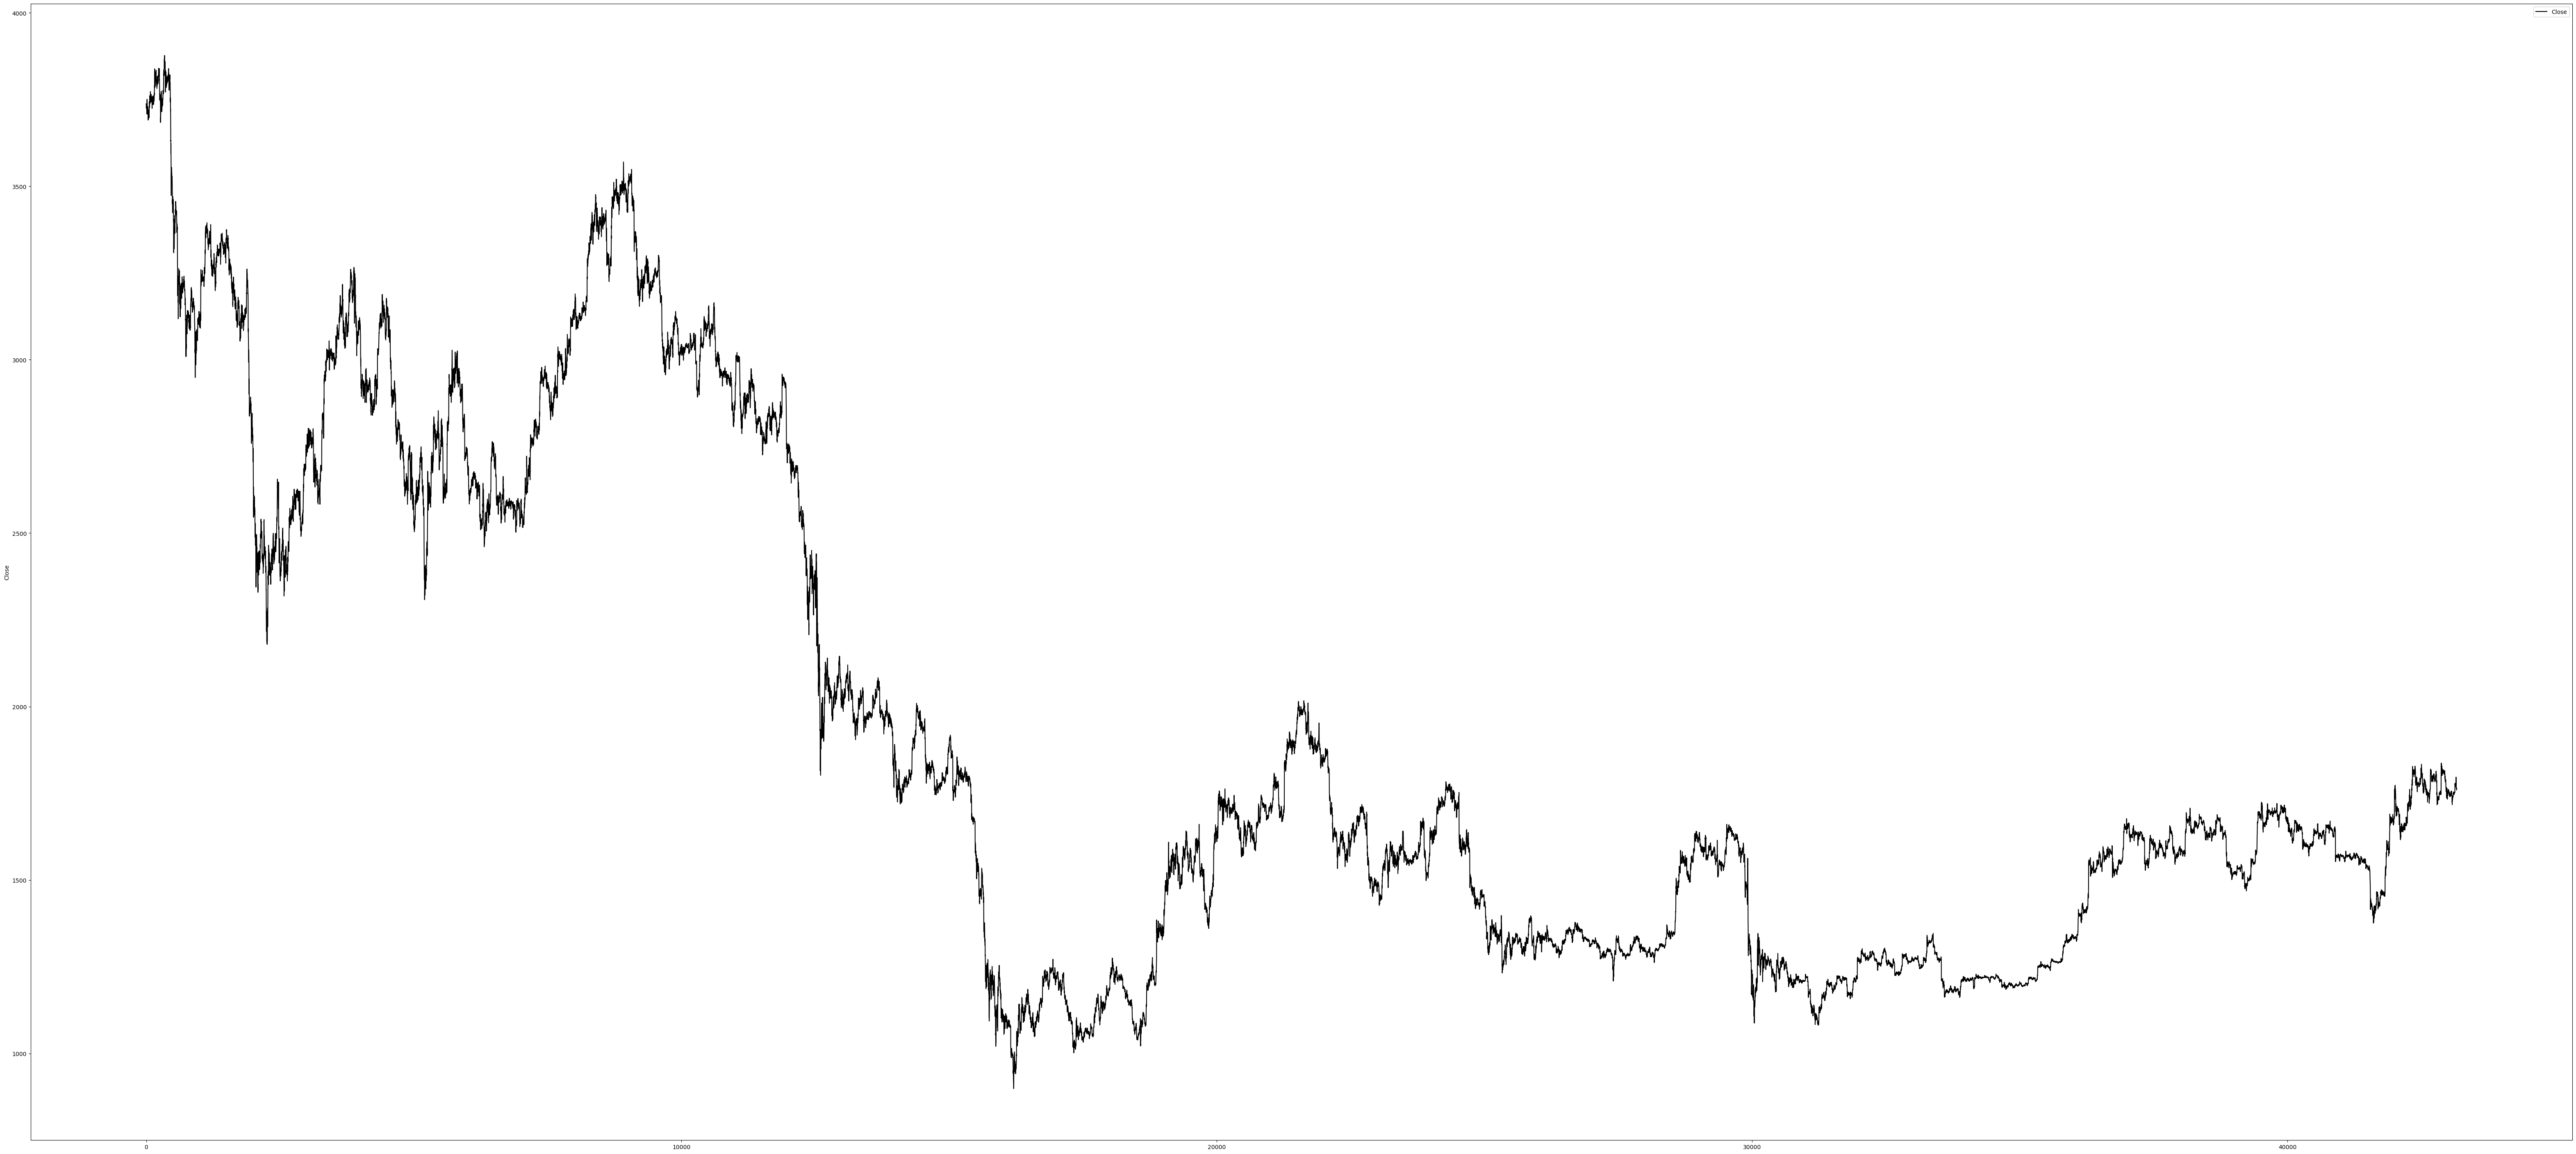

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()